# Задание 10 Сравнение методов классификации

## 1. Найти данные, на которых интересно будет решать задачу классификации
**Abalone Dataset** — это набор данных, который используется для предсказания возраста морских улиток абалон (Haliotis).

Задача: Предсказать пол морской улитки на основе различных измерений её физических параметров

Количество экземпляров: В датасете содержится 4177 записей

Целевой атрибут: Возраст улитки (количество колец на раковине)

Формат данных: Числовые значения и категориальные данные (пол)

Атрибуты:
- Sex: Пол улитки (M = мужской, F = женский, I = инфантильный)
- Length: Длина раковины (в миллиметрах)
- Diameter: Диаметр раковины (в миллиметрах)
- Height: Высота раковины (в миллиметрах)
- Whole weight: Общий вес улитки (в граммах)
- Shucked weight: Вес мяса без раковины (в граммах)
- Viscera weight: Вес внутренностей (в граммах)
- Shell weight: Вес пустой раковины (в граммах)
- Rings: Количество колец на раковине (это основной показатель возраста улитки)

### Импорт библиотек

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## 2. Считать данные, выполнить первичный анализ данных

In [36]:
data = pd.read_csv('abalone.csv')
data.columns = ["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"]

print(data.head())
print(data.info())
print(data.describe())

  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
1   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
2   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
3   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   
4   I   0.425     0.300   0.095        0.3515          0.1410          0.0775   

   Shell weight  Rings  
0         0.070      7  
1         0.210      9  
2         0.155     10  
3         0.055      7  
4         0.120      8  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4176 non-null   object 
 1   Length          4176 non-null   float64
 2   Diameter        4176 non-null   float64
 3   Height          4176 non-nu

Проверяем количество нулевых значений.

In [37]:
print(data.isnull().sum())

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64


Нет необходимости проводить чистку данных.

## 3. Выполнить разведочный анализ (EDA), использовать визуализацию

Преобразуем категоральный признак 'Sex' в числовой формат для выполнения анализа.

In [38]:
sex_mapping = {'M': 1, 'F': 2, 'I': 0}
data['Sex'] = data['Sex'].map(sex_mapping)
print(data.head())

   Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0    1   0.350     0.265   0.090        0.2255          0.0995   
1    2   0.530     0.420   0.135        0.6770          0.2565   
2    1   0.440     0.365   0.125        0.5160          0.2155   
3    0   0.330     0.255   0.080        0.2050          0.0895   
4    0   0.425     0.300   0.095        0.3515          0.1410   

   Viscera weight  Shell weight  Rings  
0          0.0485         0.070      7  
1          0.1415         0.210      9  
2          0.1140         0.155     10  
3          0.0395         0.055      7  
4          0.0775         0.120      8  


Построим диаграммы распределения количественных признаков.

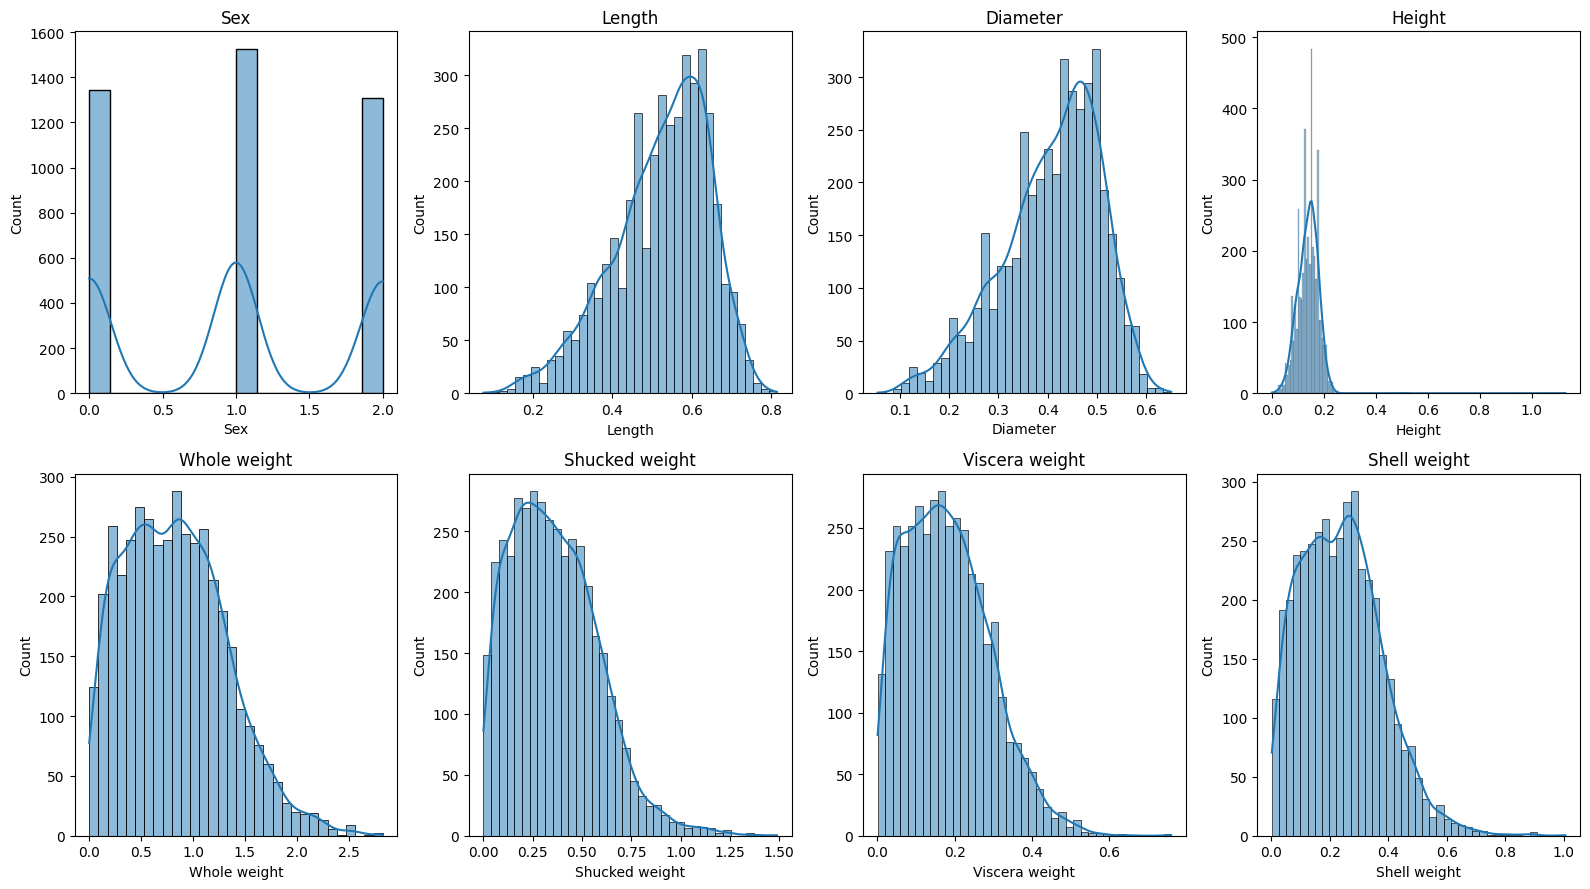

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))
for i, col in enumerate(data.columns[:-1]):
    row = int(i / 4)
    col_pos = i % 4
    sns.histplot(data=data, x=col, kde=True, ax=axes[row][col_pos])
    axes[row][col_pos].set_title(col)
plt.tight_layout()
plt.show()

Построим матрицу корреляции, чтобы посмотреть на степень взаимодействия между признаками.

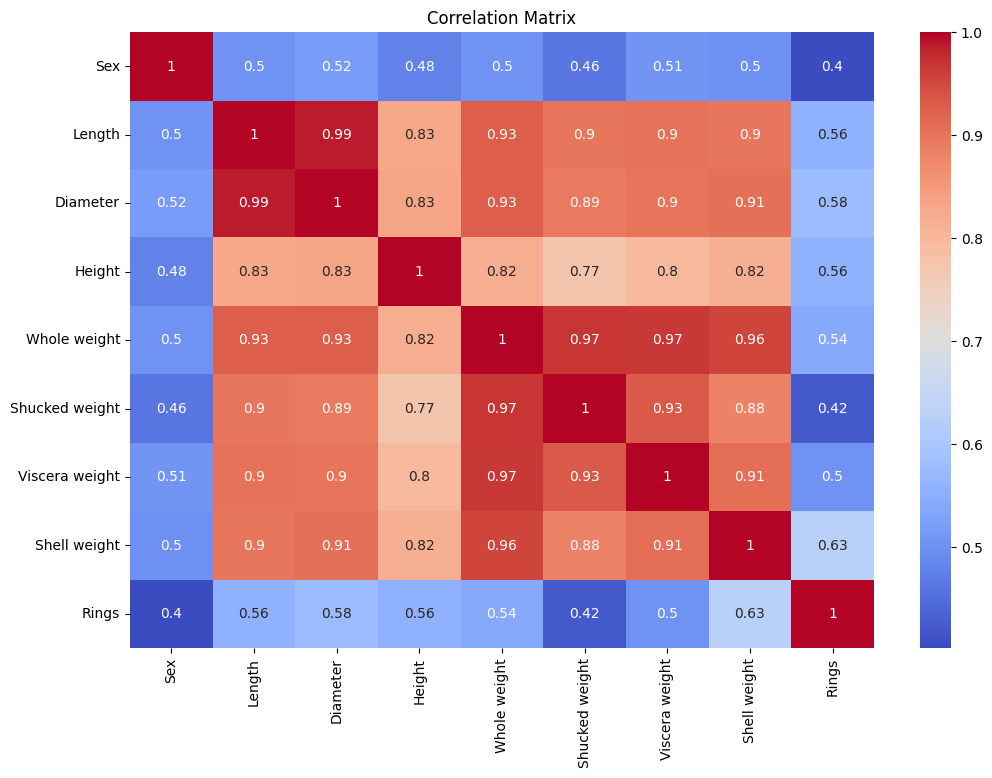

In [40]:
corr = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Исследуем распределение количества моллюсков по полу.

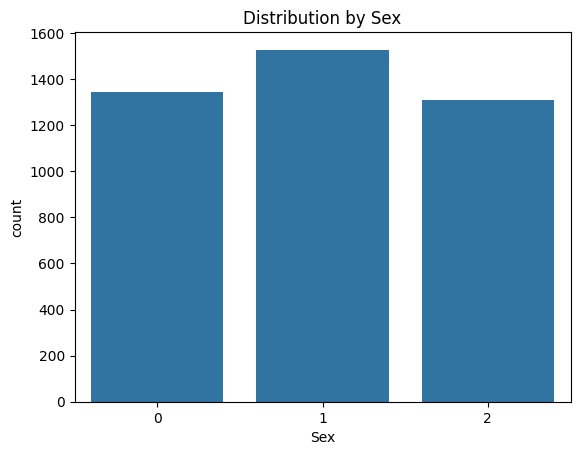

In [41]:
sns.countplot(x='Sex', data=data)
plt.title('Distribution by Sex')
plt.show()

### На основании проведенного анализа можно сделать следующие выводы:

- Все признаки имеют нормальное или близкое к нормальному распределение, за исключением некоторых выбросов.
- Признаки Length, Diameter, Height, Whole weight, Shucked weight, Viscera weight и Shell weight сильно коррелируют друг с другом, что может указывать на избыточность информации.
- Пол моллюска (Sex) распределен немного неравномерно, но имеет достаточно представителей каждой категории.

## 4. Подготовить данные

Разделим данные на обучающую и тестовую выборки.

In [42]:
X = data.drop('Sex', axis=1)
y = data['Sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

Масштабируем данные для улучшения работы моделей.

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Добиться наилучшего качества предсказания для библиотечных реализаций (например, из sklearn) четырёх методов классификации.

Рассмотрим четыре метода классификации: **логистическая регрессия, дерево решений, метод ближайших соседей и SVM**.

### Логистическая регрессия

In [44]:
log_reg = LogisticRegression(max_iter=1000)
param_grid_log_reg = {'C': [0.01, 0.1, 1, 10, 100]}
grid_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5)
grid_log_reg.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

### Случайный лес

In [45]:
rf = RandomForestClassifier()
param_grid_rf = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5)
grid_rf.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [10, 50, 100]})

### Градиентный бустинг

In [49]:
gbc = GradientBoostingClassifier()
param_grid_gbc = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
grid_gbc = GridSearchCV(gbc, param_grid_gbc, cv=5)
grid_gbc.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [50, 100, 200]})

### Метод опорных векторов

In [50]:
svm = SVC()
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_svm.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})

## 6. Сравнить все обученные модели, построить их confusion matrices

Logistic Regression Accuracy: 0.5538806931272685


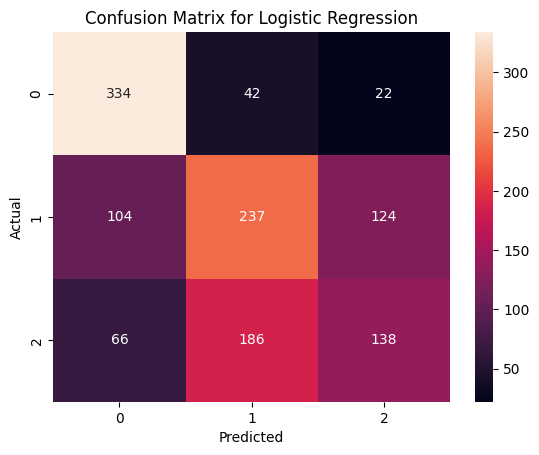

Random Forest Accuracy: 0.5449959021191898


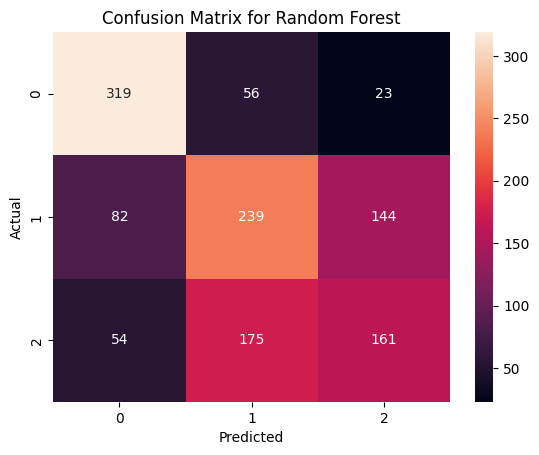

Gradient Boosting Accuracy: 0.5473902353354408


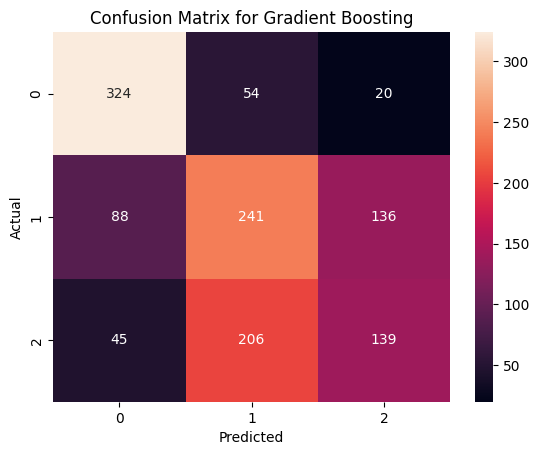

SVM Accuracy: 0.5590165086055497


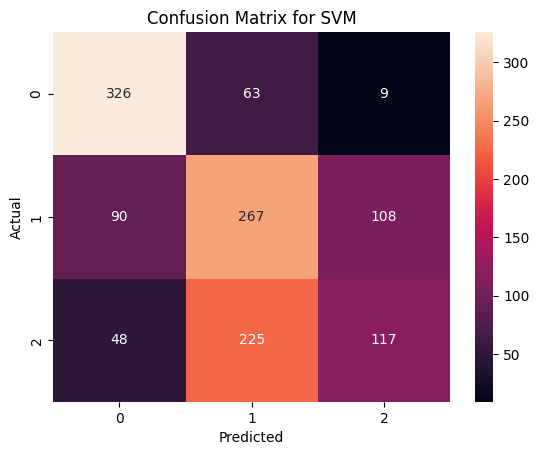

              precision    recall  f1-score   support

           0       0.70      0.82      0.76       398
           1       0.48      0.57      0.52       465
           2       0.50      0.30      0.38       390

    accuracy                           0.57      1253
   macro avg       0.56      0.56      0.55      1253
weighted avg       0.56      0.57      0.55      1253



In [51]:
models = {
    "Logistic Regression": grid_log_reg,
    "Random Forest": grid_rf,
    "Gradient Boosting": grid_gbc,
    "SVM": grid_svm
}

for model_name, model in models.items():
    print(f"{model_name} Accuracy: {model.best_score_}")

    # Генерация предсказаний и confusion matrix
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

print(classification_report(y_test, y_pred))

### Выводы
- Точность моделей варьируется примерно от 54% до 56%. Это относительно низкие значения, что говорит о том, что модели не очень хорошо распознают пол абалонов

- Для класса 0 (I) точность и полнота достаточно высокие (70% и 82%), что указывает на хорошую способность модели распознавать этот класс.

- Для класса 1 (M) точность — 48%, а полнота — 57%. Это говорит о том, что модель имеет проблемы с классификацией этого класса, часто делая ошибки, назначая объекты этого класса к другим классам.

- Класс 2 (F) имеет еще более низкие значения точности и полноты, что говорит о том, что модель испытывает трудности с этим классом, значительно увеличивая количество ошибочных классификаций.

### 7. Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров. Повторить все пункты задания для собственной реализации.

KNN Confusion Matrix:
[[316  57  25]
 [112 212 141]
 [ 70 198 122]]
              precision    recall  f1-score   support

           0       0.63      0.79      0.71       398
           1       0.45      0.46      0.45       465
           2       0.42      0.31      0.36       390

    accuracy                           0.52      1253
   macro avg       0.50      0.52      0.51      1253
weighted avg       0.50      0.52      0.50      1253



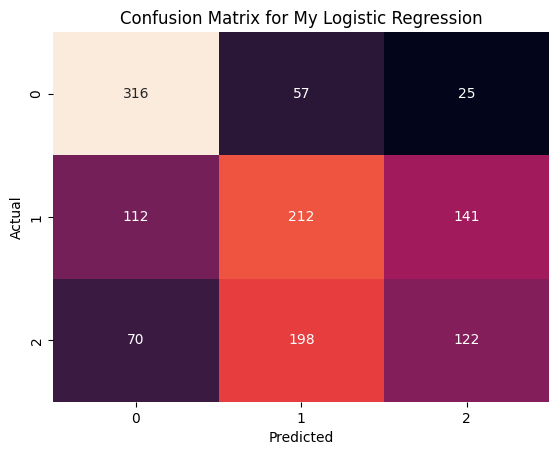

In [56]:
from sklearn.neighbors import KNeighborsClassifier

class MyKNN:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

my_knn = MyKNN(n_neighbors=5)
my_knn.fit(X_train_scaled, y_train)

y_pred_my = my_knn.predict(X_test_scaled)
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_my))
print(classification_report(y_test, y_pred_my))
cm = confusion_matrix(y_test, y_pred_my)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for My Logistic Regression')
plt.show()